In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from scipy import ndimage

from math import ceil, floor, log
import cv2

import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

True

In [3]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, Concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, PReLU
import math
import numpy as np
import os
import pickle
import time
from scipy import misc

In [4]:
# create the table
train_path = '/home/yunan/motion/patch_train/'
val_path = '/home/yunan/motion/patch_val/'

train_list = os.listdir(train_path)
val_list = os.listdir(val_path)
# print(val_list)


In [5]:
dict = {'train': train_list}
df_train = pd.DataFrame(dict) 
print(len(df_train))
    
# saving the dataframe  
# df.to_csv('train.csv', index = False)  

dict = {'val': val_list}
df_val = pd.DataFrame(dict)  
df_val.head(10)
# saving the dataframe  
# df.to_csv('val.csv', index = False)  

244800


,val
0,0_0.png
1,0_1.png
2,0_2.png
3,0_3.png
4,0_4.png
5,0_5.png
6,0_6.png
7,0_7.png
8,0_8.png
9,0_9.png


In [6]:
# import random
# random.seed(42)


# pp = r'C:\Users\YuNan\Downloads\motion\img_full\train\0_0_all.png'
# both = cv2.imread(pp)

# h, w, c = both.shape
# half_w = int(w/2)
# orig =  both[:, :half_w, 0]
# motion = both[:, half_w:, 0]
# orig = np.expand_dims(orig, axis=-1)
# motion = np.expand_dims(motion, axis=-1)

# transformed = transform(image=orig, motion=motion)

# plt.imshow(transformed['image'],cmap='gray')

In [7]:
# define data generator
# train_images_dir = "C:/Users/YuNan/Downloads/motion/breast2/train/"
# val_images_dir = "C:/Users/YuNan/Downloads/motion/breast2/val/"

train_images_dir = '/home/yunan/motion/patch_train/'
val_images_dir = '/home/yunan/motion/patch_val/'

# import albumentations as A
from matplotlib import pyplot as plt
import random
random.seed(42)

# transform = A.Compose(
#     [
#         A.HorizontalFlip(p=0.2),
#         A.ShiftScaleRotate(p=0.3),
#         A.VerticalFlip(p=0.2)
#     ],
#     additional_targets={'motion': 'image'}
# )

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,img_dir, batch_size=32, dim=(64, 64), n_channels=1, shuffle=True, Augment=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
#         self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.img_dir = img_dir
        self.shuffle = shuffle
        self.Augment = Augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            both = cv2.imread(self.img_dir + ID)
#             print(self.img_dir + ID)
            h, w, c = both.shape
            half_w = int(w/2)
            orig =  both[:, :half_w, 0]
            motion = both[:, half_w:, 0]
            orig = np.expand_dims(orig, axis=-1)
            motion = np.expand_dims(motion, axis=-1)
            
            pp = random.uniform(0, 1)
            if self.Augment and pp<0.4:
                transformed = transform(image=orig, motion=motion)
                X[i,] = transformed['motion']
                y[i,] = transformed['image']               
            else:
                X[i,] = motion
                y[i,] = orig
        X = X/255.0
        y = y/255.0
        return X, y

In [8]:
df_train = df_train.set_index(['train'])
df_val = df_val.set_index(['val'])
df_train.index

Index(['0_0.png', '0_1.png', '0_2.png', '0_3.png', '0_4.png', '0_5.png',
       '0_6.png', '0_7.png', '0_8.png', '0_9.png',
       ...
       '1223_190.png', '1223_191.png', '1223_192.png', '1223_193.png',
       '1223_194.png', '1223_195.png', '1223_196.png', '1223_197.png',
       '1223_198.png', '1223_199.png'],
      dtype='object', name='train', length=244800)

In [9]:
input_size = (64,64)
train_seq = DataGenerator(df_train.index, img_dir=train_images_dir, batch_size=16, dim = input_size, 
                          n_channels=1, shuffle=True, Augment = False)
val_seq = DataGenerator(df_val.index, img_dir=val_images_dir, batch_size=16, dim = input_size, 
                          n_channels=1, shuffle=False, Augment = False)

In [10]:
print(len(train_seq))
len(val_seq)

15300


4279

In [11]:
# model
import copy
n_f = 32
def conv_block(x, n_f, strides_x, strides_y):
    x2 = Conv2D(filters=n_f, kernel_size=(3,3), strides=(strides_x, strides_y), kernel_initializer='he_normal', padding='same')(x)
    x2 = BatchNormalization(axis=-1, epsilon=1e-3)(x2)
    x2 = LeakyReLU(alpha=0.3)(x2)
    return x2
#####U-net block####
def m_block(x):
    x2 = conv_block(x, n_f, 1, 1)
    x2 = conv_block(x2, n_f, 1, 1)
#     x2 = Dropout(0.3)(x2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    
    x3 = conv_block(pool2, n_f, 1, 1)
    x3 = conv_block(x3, n_f, 1, 1)
#     x3 = Dropout(0.3)(x3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    
    x4 = conv_block(pool3, n_f, 1, 1)
    x4 = conv_block(x4, n_f, 1, 1)
#     x4 = Dropout(0.3)(x4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)

    x5 = conv_block(pool4, n_f, 1, 1)
    x5 = conv_block(x5, n_f, 1, 1)
#     x5 = Dropout(0.3)(x5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(x5)
    
    x6 = conv_block(pool5, n_f, 1, 1)
    x6 = conv_block(x6, n_f, 1, 1)
#     x6 = Dropout(0.3)(x6)
    
    up7 = UpSampling2D(size = (2,2))(x6)
    up7 = conv_block(up7, n_f, 1, 1)
    merge7 = Concatenate(axis=-1)([x5,up7])
    x7 = conv_block(merge7, n_f, 1, 1)
    x7 = conv_block(x7, n_f, 1, 1)
#     x7 = Dropout(0.3)(x7)
    
    up8 = UpSampling2D(size = (2,2))(x7)
    up8 = conv_block(up8, n_f, 1, 1)
    merge8 = Concatenate(axis=-1)([x4,up8])
    x8 = conv_block(merge8, n_f, 1, 1)
    x8 = conv_block(x8, n_f, 1, 1)
#     x8 = Dropout(0.3)(x8)

    up9 = UpSampling2D(size = (2,2))(x8)
    up9 = conv_block(up9, n_f, 1, 1)
    merge9 = Concatenate(axis=-1)([x3,up9])
    x9 = conv_block(merge9, n_f, 1, 1)
    x9 = conv_block(x9, n_f, 1, 1)
#     x9 = Dropout(0.3)(x9)
    
    up10 = UpSampling2D(size = (2,2))(x9)
    up10 = conv_block(up10, n_f, 1, 1)
    merge10 = Concatenate(axis=-1)([x2,up10])
    x10 = conv_block(merge10, n_f, 1, 1)
    x10 = conv_block(x10, n_f, 1, 1)
#     x10 = Dropout(0.3)(x10)
    return x10
#####res block##########
def res_block(x_in,n_layer):
    for i in range(n_layer):
        x_r = m_block(x_in)
    x_r_block = tensorflow.keras.layers.Add()([x_in, x_r])
    x_r_block = LeakyReLU(alpha=0.3)(x_r_block)
    return x_r_block
#####dense block#########
def dense_block(x, n_layer):
    list_feat = [x]
#     x2 = m_block(x)
#     list_feat.append(x2)
#     concat2 = Concatenate(axis=-1)(list_feat)
    
#     x3 = m_block(concat2)
#     list_feat.append(x3)
#     concat3 = Concatenate(axis=-1)(list_feat)
    
#     return concat3|
    for i in range(n_layer):
        x = m_block(x)
        list_feat.append(x)
        x = Concatenate(axis=-1)(copy.copy(list_feat))
#         print(list_feat)
    return x

In [12]:
inpt = Input(shape=(None,None,1))
######dense net######
x_b = dense_block(inpt, 3)

######res net
# x_b = res_block(inpt,1)
# for i in range(2):
#     x_b = res_block(x_b,1)
#########
x_b = conv_block(x_b, 1, 1, 1)
# print(x_b)
x_out = tensorflow.keras.layers.Subtract()([inpt, x_b])   # input - noise
# print(x_out)
autoencoder = Model(inputs=inpt, outputs=x_out)


autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
autoencoder.load_weights('/home/yunan/motion/model/model_try.hdf5')

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', # mae, loss
                   verbose=1, 
                   patience=8, 
                   min_delta=0.0000000001, 
                   mode='min')
mc = ModelCheckpoint('/home/yunan/motion/model/model_denoising2.hdf5', 
                     monitor='val_loss', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss',
                        mode='min',
                        factor=0.1,
                        patience=8)

In [15]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=['mse'],metrics=['mae'])

In [16]:
# autoencoder.load_weights('/home/yunan/motion/model/perceptual_aug2.hdf5', by_name=True)

In [ ]:
hist = autoencoder.fit_generator(train_seq, epochs=200, verbose=1, max_queue_size=1, 
                           workers=1, validation_data=val_seq, 
                           callbacks = [es, mc,rlr], use_multiprocessing=False)

Epoch 1/200
 3949/15300 [======>.......................] - ETA: 1:45:09 - loss: 0.0085 - mae: 0.0546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0488
Epoch 00001: val_loss improved from inf to 0.00542, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9533s 623ms/step - loss: 0.0068 - mae: 0.0488 - val_loss: 0.0054 - val_mae: 0.0442
Epoch 2/200
15299/15300 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0422
Epoch 00002: val_loss improved from 0.00542 to 0.00431, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9658s 631ms/step - loss: 0.0050 - mae: 0.0422 - val_loss: 0.0043 - val_mae: 0.0397
Epoch 3/200
 8155/15300 [==============>...............] - ETA: 1:07:11 - loss: 0.0044 - mae: 0.0399

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0394
Epoch 00003: val_loss improved from 0.00431 to 0.00395, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9646s 630ms/step - loss: 0.0043 - mae: 0.0394 - val_loss: 0.0040 - val_mae: 0.0386
Epoch 4/200
 2408/15300 [===>..........................] - ETA: 2:00:37 - loss: 0.0040 - mae: 0.0380

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0375
Epoch 00004: val_loss improved from 0.00395 to 0.00365, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9675s 632ms/step - loss: 0.0039 - mae: 0.0375 - val_loss: 0.0037 - val_mae: 0.0367
Epoch 5/200
 5268/15300 [=========>....................] - ETA: 1:33:52 - loss: 0.0037 - mae: 0.0365

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9593/15300 [=================>............] - ETA: 53:18 - loss: 0.0036 - mae: 0.0363

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0361
Epoch 00005: val_loss improved from 0.00365 to 0.00324, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9540s 624ms/step - loss: 0.0036 - mae: 0.0361 - val_loss: 0.0032 - val_mae: 0.0348
Epoch 6/200
  535/15300 [>.............................] - ETA: 2:13:01 - loss: 0.0036 - mae: 0.0358

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7068/15300 [============>.................] - ETA: 1:13:26 - loss: 0.0034 - mae: 0.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12738/15300 [=======================>......] - ETA: 22:50 - loss: 0.0034 - mae: 0.0352

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0032 - mae: 0.0342
Epoch 00007: val_loss improved from 0.00310 to 0.00292, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9188s 601ms/step - loss: 0.0032 - mae: 0.0342 - val_loss: 0.0029 - val_mae: 0.0329
Epoch 8/200
15299/15300 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.0335
Epoch 00008: val_loss improved from 0.00292 to 0.00291, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9348s 611ms/step - loss: 0.0031 - mae: 0.0335 - val_loss: 0.0029 - val_mae: 0.0327
Epoch 9/200
15299/15300 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0329
Epoch 00009: val_loss improved from 0.00291 to 0.00273, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9575s 626ms/step - loss: 0.0030 - mae: 0.0329 - val_loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8678/15300 [================>.............] - ETA: 1:02:08 - loss: 0.0028 - mae: 0.0319

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15299/15300 [============================>.] - ETA: 0s - loss: 0.0028 - mae: 0.0319
Epoch 00011: val_loss improved from 0.00273 to 0.00260, saving model to /home/yunan/motion/model/model_denoising2.hdf5
15300/15300 [==============================] - 9608s 628ms/step - loss: 0.0028 - mae: 0.0319 - val_loss: 0.0026 - val_mae: 0.0309
Epoch 12/200
10230/15300 [===================>..........] - ETA: 47:29 - loss: 0.0027 - mae: 0.0315

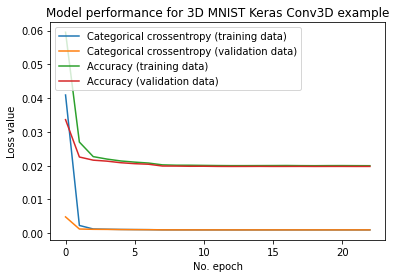

In [26]:
# Plot history: Categorical crossentropy & Accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(hist.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(hist.history['mae'], label='Accuracy (training data)')
plt.plot(hist.history['val_mae'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

# testing

In [27]:
autoencoder.load_weights('/home/yunan/motion/model/model_try.hdf5')

In [28]:
# create the table
train_path = '/home/yunan/motion/train/'
val_path = '/home/yunan/motion/val/'
# train_path = 'C:/Users/YuNan/Downloads/motion/img_full/z/'
# val_path = 'C:/Users/YuNan/Downloads/motion/img_full/z_val/'

train_list = os.listdir(train_path)
val_list = os.listdir(val_path)
# print(val_list)


In [29]:
dict = {'train': train_list}
df_train = pd.DataFrame(dict)  
    
# saving the dataframe  
# df.to_csv('train.csv', index = False)  

dict = {'val': val_list}
df_val = pd.DataFrame(dict)  
df_val.head(10)
# saving the dataframe  
# df.to_csv('val.csv', index = False)

,val
0,107_0_all.png
1,107_0_random.png
2,107_0_sin.png
3,107_100_all.png
4,107_100_random.png
5,107_100_sin.png
6,107_101_all.png
7,107_101_random.png
8,107_101_sin.png
9,107_102_all.png


In [30]:
df_train = df_train.set_index(['train'])
df_val = df_val.set_index(['val'])
df_train.index

Index(['0_0_all.png', '0_0_random.png', '0_0_sin.png', '0_100_all.png',
       '0_100_random.png', '0_100_sin.png', '0_101_all.png',
       '0_101_random.png', '0_101_sin.png', '0_102_all.png',
       ...
       '9_97_sin.png', '9_98_all.png', '9_98_random.png', '9_98_sin.png',
       '9_99_all.png', '9_99_random.png', '9_99_sin.png', '9_9_all.png',
       '9_9_random.png', '9_9_sin.png'],
      dtype='object', name='train', length=126300)

In [33]:
input_size = (64, 64)
train_seq = DataGenerator(df_train.index, img_dir=train_path, batch_size=1, dim = input_size, 
                          n_channels=1, shuffle=False, Augment = False)
val_seq = DataGenerator(df_val.index, img_dir=val_path , batch_size=1, dim = input_size, 
                          n_channels=1, shuffle=False, Augment = False)
predicted_train = autoencoder.predict_generator(train_seq)
predicted_val = autoencoder.predict_generator(val_seq)

KeyboardInterrupt: 

In [ ]:
def __data_generation(list_IDs_temp, batch_size, dim, n_channels, img_dir):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((batch_size, dim, dim,  n_channels))
    y = np.empty((batch_size, dim, dim, n_channels))
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
#             print(ID)
        both = cv2.imread(img_dir + ID)
        h, w, c = both.shape
        half_w = int(w/2)
        orig =  both[:, :half_w, 0]
        motion = both[:, half_w:, 0]
        orig = np.expand_dims(orig, axis=-1)
        motion = np.expand_dims(motion, axis=-1)
        X[i,] = motion
        y[i,] = orig
    X = X/255.0
    y = y/255.0
#         triple_y = np.concatenate((y, y, y),axis=-1)
#         triple_y = lossModel.predict(triple_y)
    return X, y

In [ ]:
# train
motion, Y_orig  = __data_generation(df_train.index, predicted_train.shape[0], 512, 1, train_path)

In [102]:
# predict SSIM ans MSE
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

SS = []
MSE = []
for i in range(Y_orig.shape[0]):
    score, diff = ssim(Y_orig[i,:,:,0], predicted_train[i,:,:,0], full=True)
    mse = mean_squared_error(Y_orig[i,:,:,0], predicted_train[i,:,:,0])
    SS.append(score)
    MSE.append(mse)


C:\Users\YuNan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  


In [111]:
print(ssim(val_motion[1,:,:,0], val_Y_orig[1,:,:,0]))

0.9499467067925592


In [112]:
# val
val_motion, val_Y_orig  = __data_generation(df_val.index, predicted_val.shape[0], 512, 1, val_path)

# predict SSIM ans MSE
val_SS = []
val_MSE = []
for i in range(val_Y_orig.shape[0]):
    score = ssim(val_motion[i,:,:,0], val_Y_orig[i,:,:,0])
    mse = mean_squared_error(val_motion[i,:,:,0], val_Y_orig[i,:,:,0])
    val_SS.append(score)
    val_MSE.append(mse)

In [113]:
# analysis all data
print('ssim_mean:' ,np.mean(SS), 'ssim_std:', np.std(SS))
print('val_ssim_mean:' ,np.mean(val_SS), 'val_ssim_std:', np.std(val_SS))

print('mse_mean:' ,np.mean(MSE), 'mse_std:', np.std(MSE))
print('val_mse_mean:' ,np.mean(val_MSE), 'val_mse_std:', np.std(val_MSE))

ssim_mean: 0.9679527272360342 ssim_std: 0.008540231000591599
val_ssim_mean: 0.9529477811751843 val_ssim_std: 0.00896055297450749
mse_mean: 0.0002831023382492031 mse_std: 0.00010111178326273984
val_mse_mean: 0.00031270934753535297 val_mse_std: 7.254559109703634e-05


# single image

In [34]:
# pp = './test/'
# test_list = os.listdir(pp)
# # test_list
# pred = np.zeros((64 * 8,64 * 8))
# for i in range(8):
#     for j in range(8):
#         both = cv2.imread(pp + test_list[i * 8 + j])
#         half_w = 64
#         orig =  both[:, :half_w, 0]/255.0
#         motion = both[:, half_w:, 0]/255.0
#     #     orig = np.expand_dims(orig, axis=-1)
#         motion = np.expand_dims(motion, axis=-1)
#         motion = np.expand_dims(motion, axis=0)

#         predicted = autoencoder.predict(motion)
#     #     print(predicted == motion)
#         predicted = predicted[0,:,:,0]
#         pred[i*64:(i+1)*64, j*64:(j+1)*64] = predicted
#         plt.imsave('./test_pred/{}.png'.format(i), predicted,cmap='gray')
        
# plt.imsave('./test_pred/all.png', pred,cmap='gray')

In [38]:
both = cv2.imread('/home/yunan/motion/liver paper real motion test images/motion_img/1.2.840.113619.2.322.2807.623845.18823.1475583923.185_0800_000027_1571088180d3de..png')
# print(both.shape)
# np.max(both)
motion_img = both[:,:,0]/255.0
# motion_img
pred = np.zeros((64 * 8,64 * 8))
# motion_img.shape
# np.array_equal(both[:, 512:, 0], both[:, 512:, 1])
for i in range(8):
    for j in range(8):
        motion = motion_img[i*64:(i+1)*64, j*64:(j+1)*64]
        motion = np.expand_dims(motion, axis=-1)
        motion = np.expand_dims(motion, axis=0)    
        predicted = autoencoder.predict(motion)
        predicted = predicted[0,:,:,0]
        pred[i*64:(i+1)*64, j*64:(j+1)*64] = predicted
        plt.imsave('./test_pred/{}_{}.png'.format(i,j), predicted,cmap='gray')
plt.imsave('./test_pred/all.png', pred,cmap='gray')

In [17]:
# both = cv2.imread('both.png')
# predictt = cv2.imread('./test_pred/all.png')

In [33]:
both = cv2.imread('val.png')
print(both.shape)
# np.max(both)
motion = both[:, 512:, 0]/255.0
plt.imsave('./motion.png', motion, cmap='gray')
motion = np.expand_dims(motion, axis=-1)
motion = np.expand_dims(motion, axis=0) 
print(motion.shape)
predicted = autoencoder.predict(motion)
print(predicted.shape)
predict_img = predicted.reshape(512,512)
plt.imsave('./all.png', predict_img, cmap='gray')

(512, 1024, 3)
(1, 512, 512, 1)
(1, 512, 512, 1)
